In [10]:
# Cell 1: Setup and Data Loading
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid", palette="viridis")

try:
    file_name = '../report/central.csv'
    df = pd.read_csv(file_name)
    
    df['total_time_mean'] = pd.to_numeric(df['total_time_mean'])
    df['comm_time_mean'] = pd.to_numeric(df['comm_time_mean'])
    df['comp_time_mean'] = pd.to_numeric(df['comp_time_mean'])
    df['total_time_std'] = pd.to_numeric(df['total_time_std'])

    print("Data loaded and preprocessed successfully!")
    df.head()
    # print the first few rows of the dataframe
    print(df.head())

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    print("Please make sure the CSV file is in the correct directory and the filename is correct.")
    df = pd.DataFrame()

Data loaded and preprocessed successfully!
    comm_type  matrix_size  num_procs  nodes  environment  total_time_mean  \
0  collective          512         32      1       713283         0.039553   
1  collective         1024         32      1       713283         0.292695   
2  collective         2048         32      1       713283         6.504240   
3        sync          512         32      1       713283         0.037889   
4        sync         1024         32      1       713283         0.295437   

   total_time_std  comm_time_mean  comm_time_std  comp_time_mean  \
0        0.000272        0.026150       0.001919        0.028481   
1        0.004203        0.160454       0.004351        0.262233   
2        0.369688        3.358064       0.400511        6.419826   
3        0.001068        0.018953       0.001262        0.026956   
4        0.003839        0.160139       0.002823        0.265867   

   comp_time_std  repetitions  
0       0.000129            3  
1       0.00495

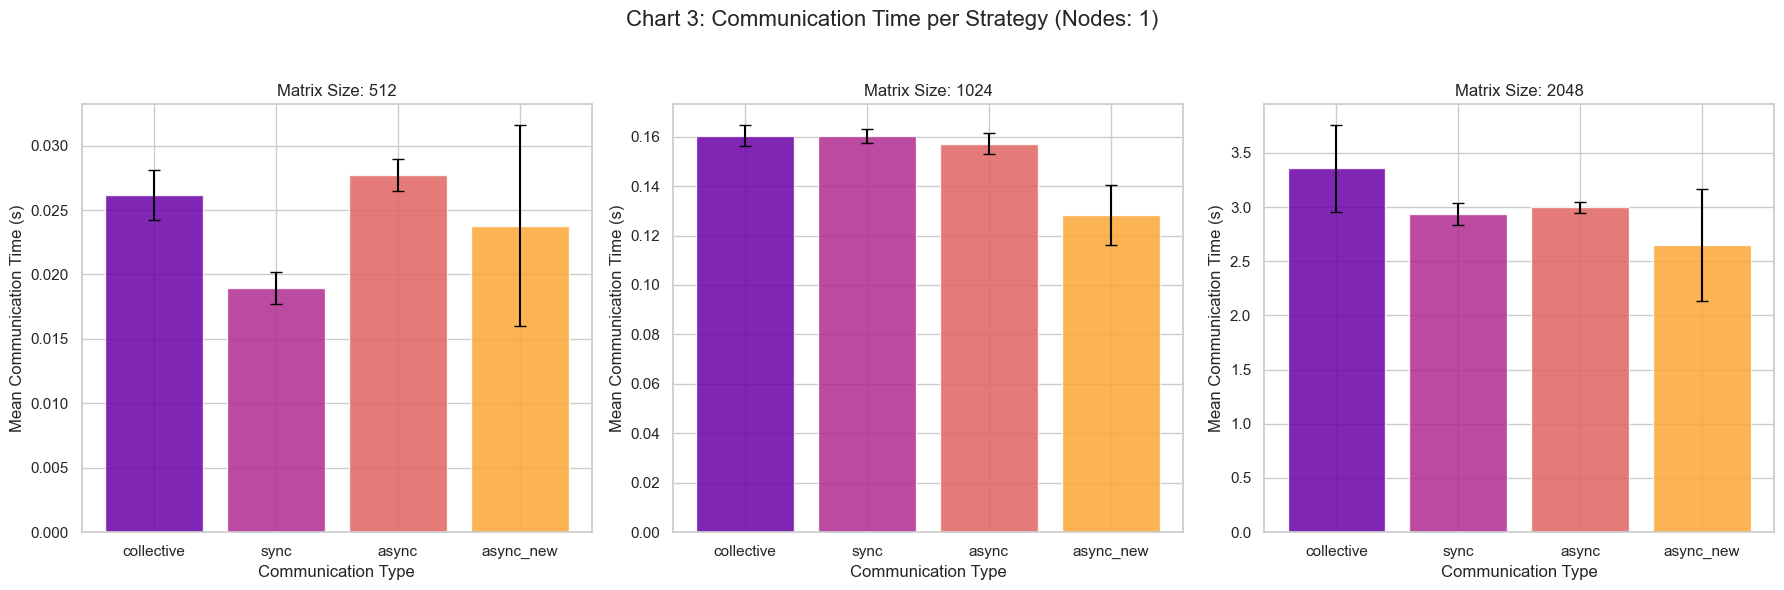

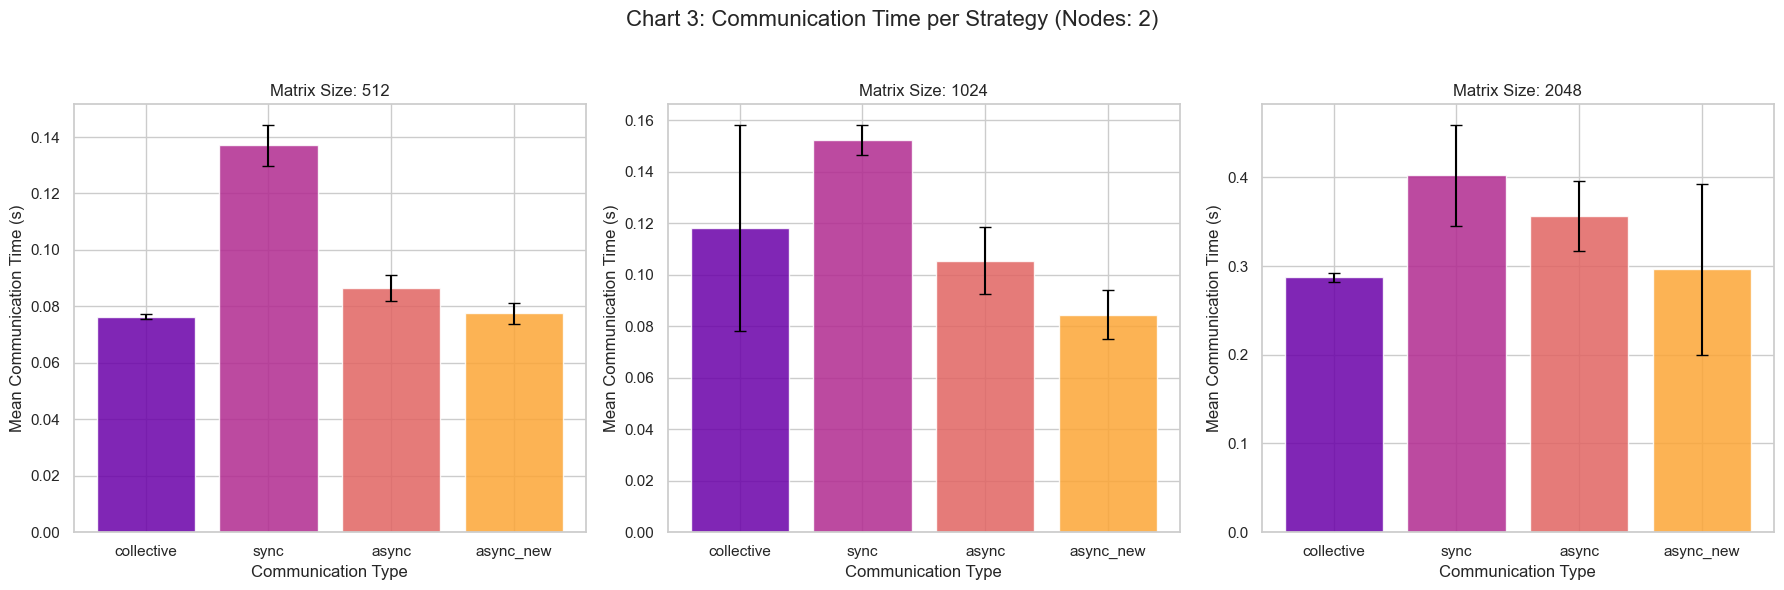

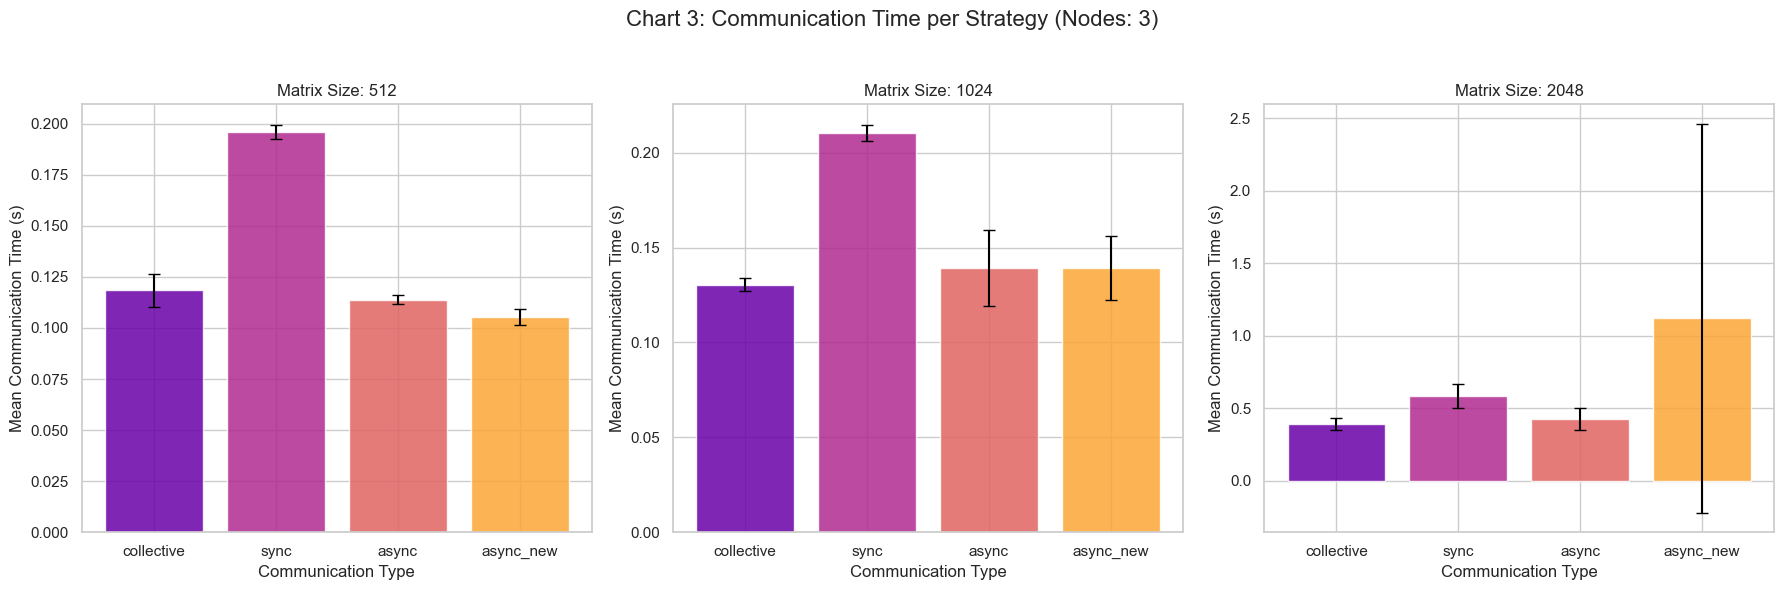

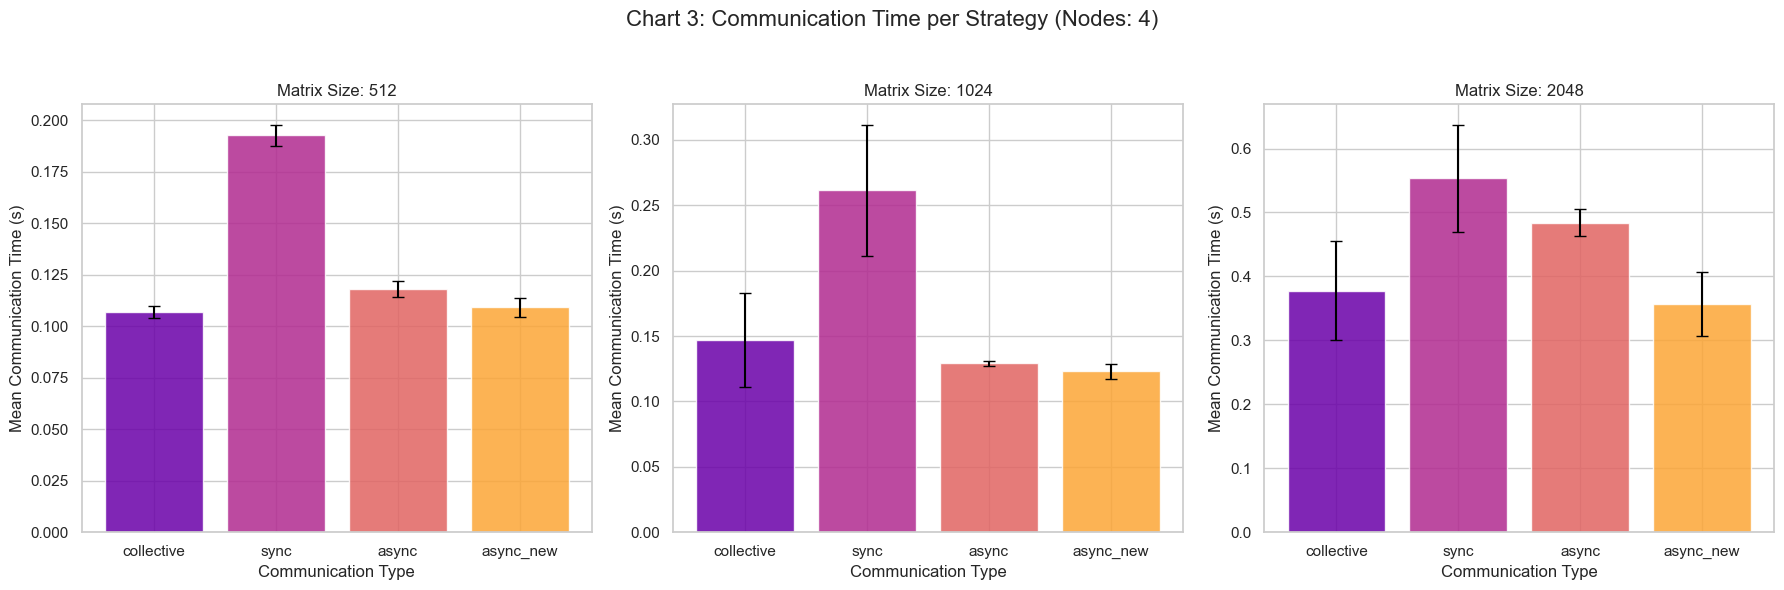

In [ ]:
# Chart 3: Separate Bar Charts for Each Node with Communication Name on Bars and Separate Y-Axis

df_chart3 = df[df['num_procs'] == 32].copy()

# Ensure comm_time_std exists
if 'comm_time_std' not in df_chart3.columns:
    df_chart3['comm_time_std'] = 0.0

import matplotlib.pyplot as plt
import seaborn as sns

node_counts = sorted(df_chart3['nodes'].unique())
comm_types = df_chart3['comm_type'].unique()

for node in node_counts:
    fig, axes = plt.subplots(1, len(df_chart3['matrix_size'].unique()), figsize=(6 * len(df_chart3['matrix_size'].unique()), 6), sharey=False)
    if len(df_chart3['matrix_size'].unique()) == 1:
        axes = [axes]
    for ax, matrix_size in zip(axes, sorted(df_chart3['matrix_size'].unique())):
        subset = df_chart3[(df_chart3['nodes'] == node) & (df_chart3['matrix_size'] == matrix_size)]
        bars = ax.bar(
            subset['comm_type'],
            subset['comm_time_mean'],
            yerr=subset['comm_time_std'],
            capsize=4,
            color=sns.color_palette('plasma', n_colors=len(subset['comm_type'])),
            alpha=0.85
        )
        ax.set_title(f'Matrix Size: {matrix_size}')
        ax.set_xlabel('Communication Type')
        ax.set_ylabel('Mean Communication Time (s)')
    fig.suptitle(f'Chart 3: Communication Time per Strategy (Nodes: {node})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

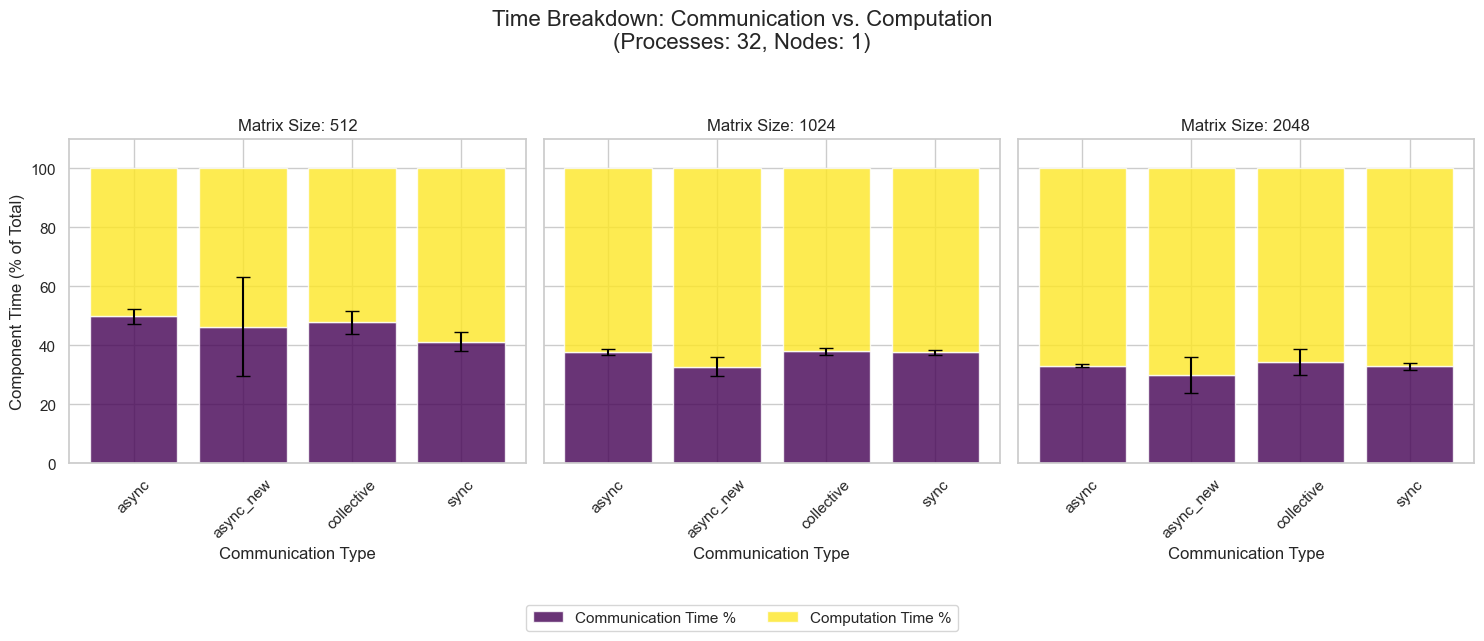

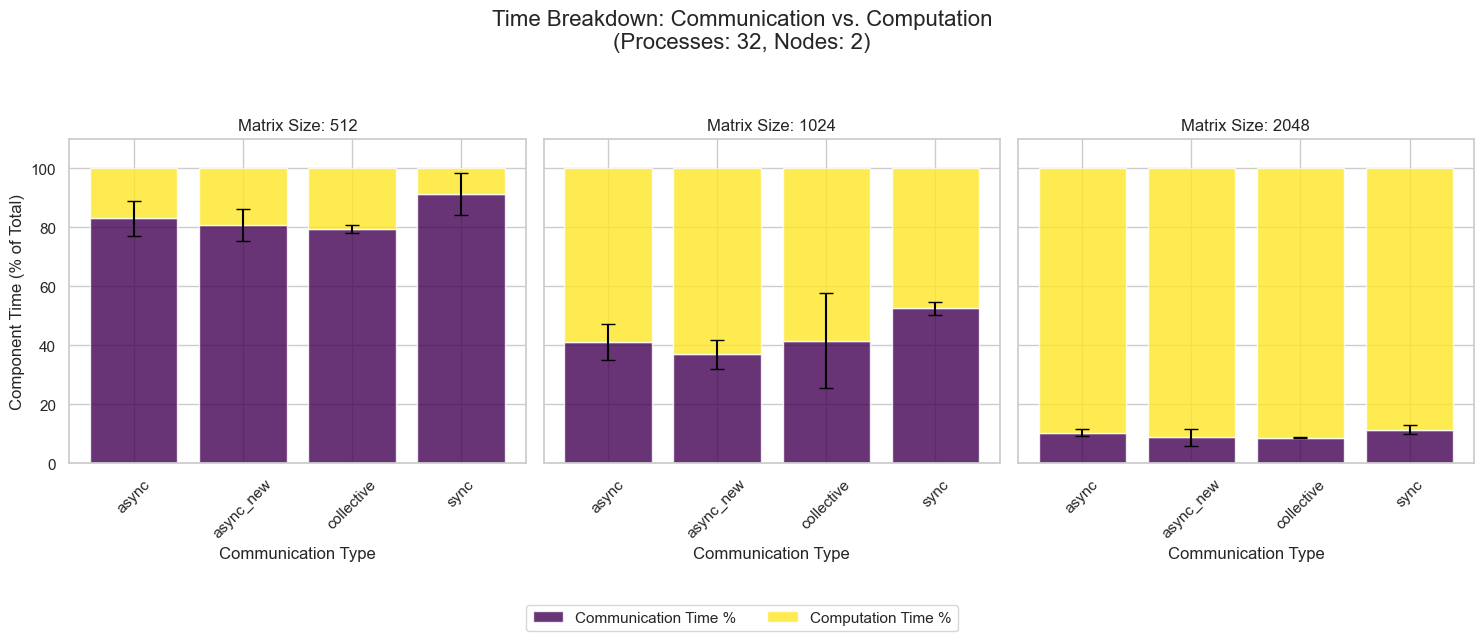

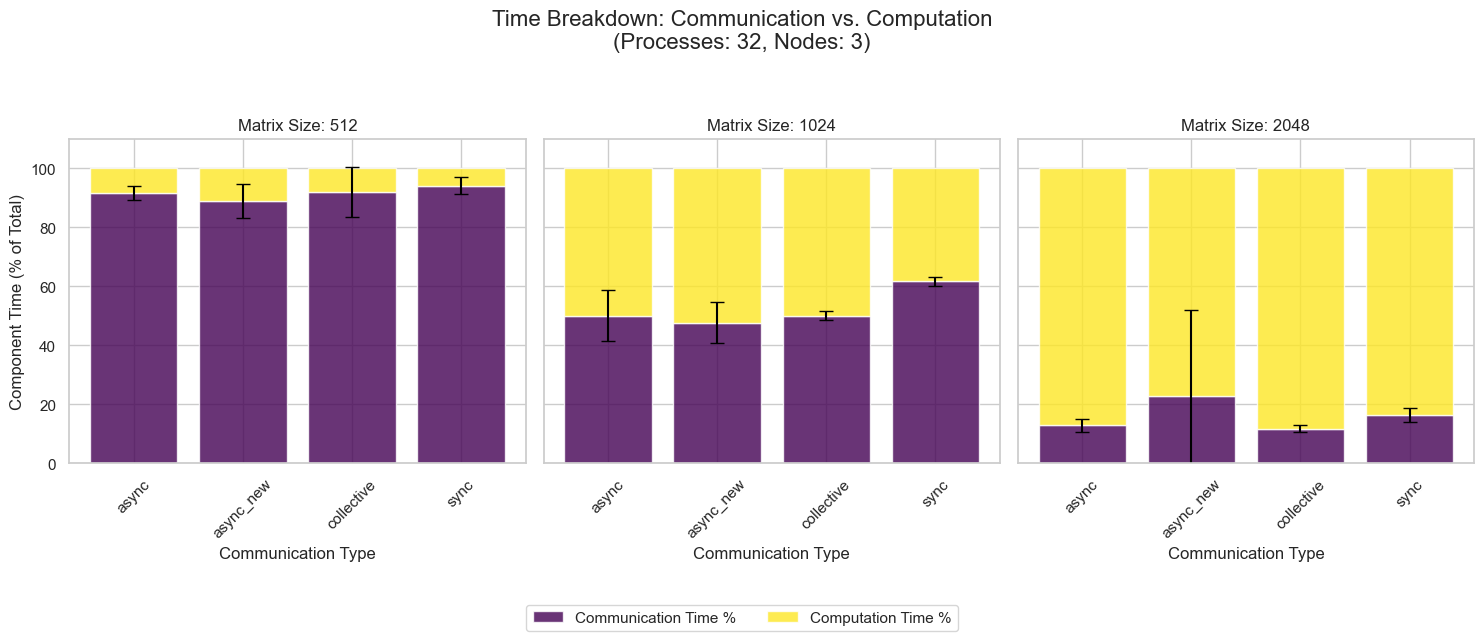

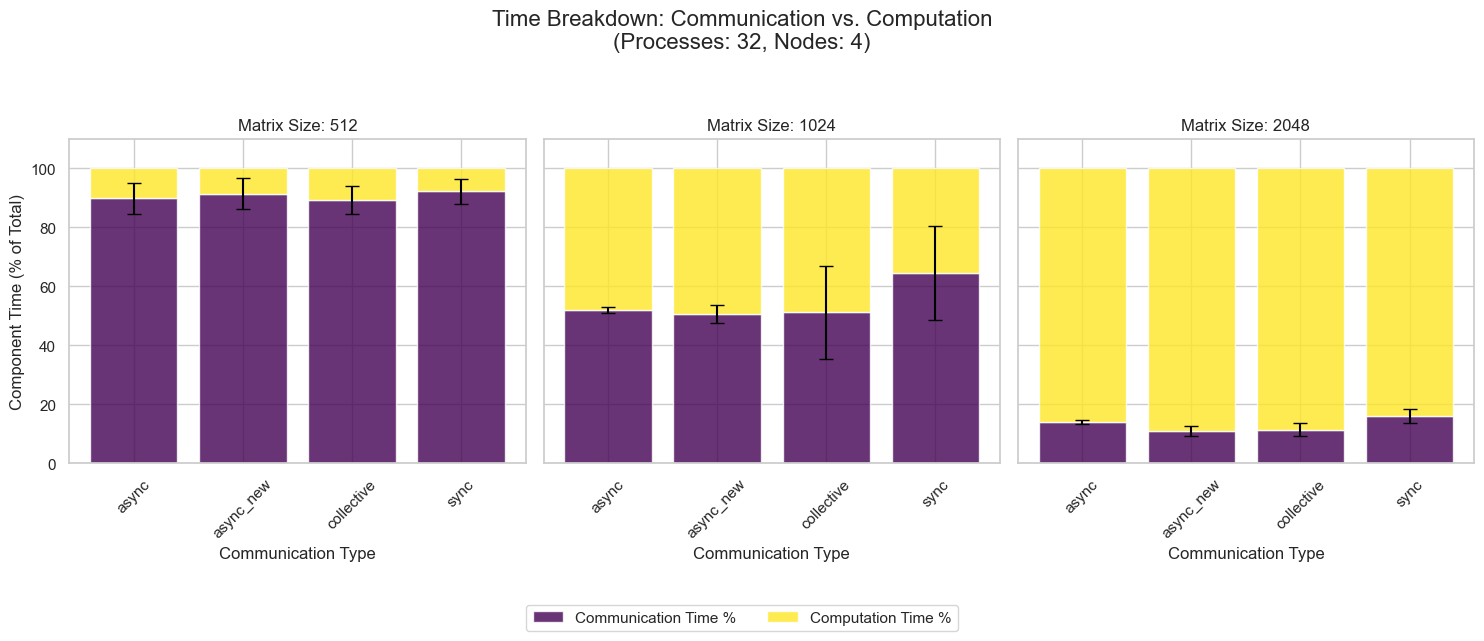

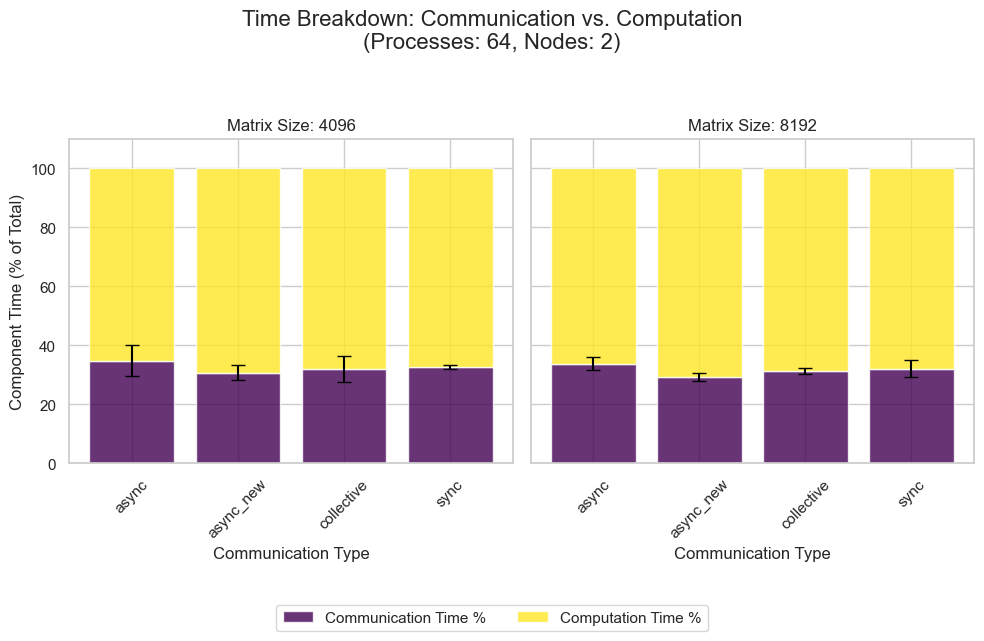

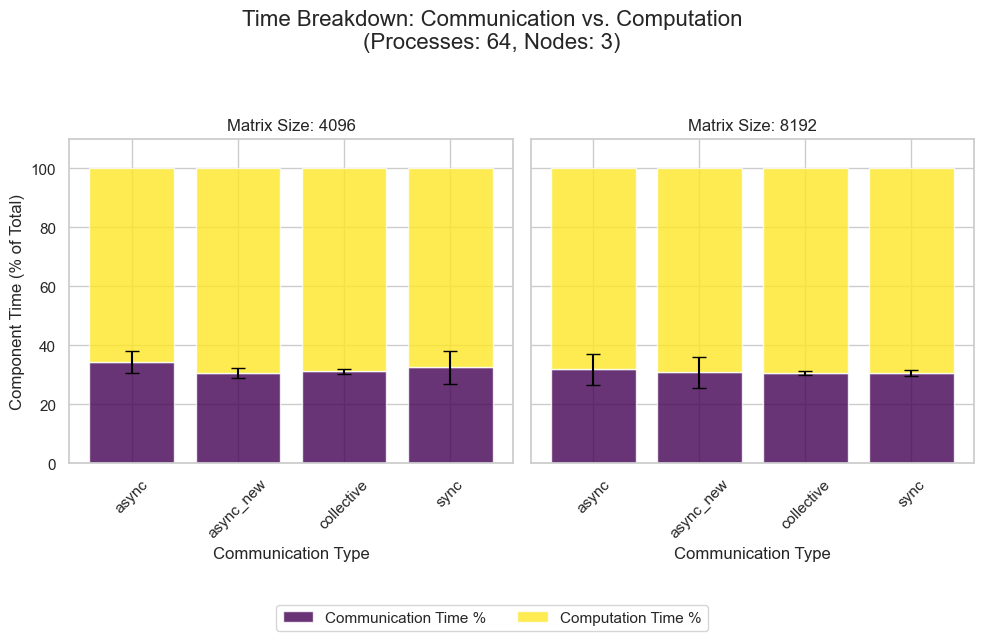

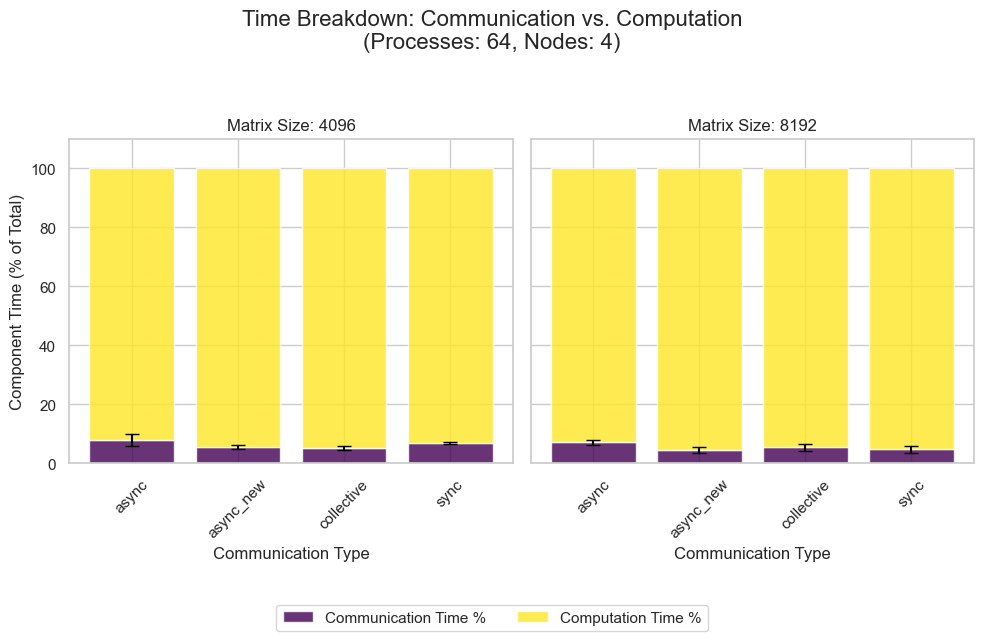

In [25]:
# Cell 2: Generate Percentage Stacked Bar Charts (Revised)

# --- Step 1: Calculate Percentages and Propagate Errors ---
# In this version, total_time = comm_time + comp_time

# Create a copy to avoid modifying the original DataFrame
df_perc = df.copy()

# Define the new total time as the sum of its components
df_perc['total_time_mean_new'] = df_perc['comm_time_mean'] + df_perc['comp_time_mean']

# Propagate the standard deviation for the new total time.
# Assuming comm and comp times are independent: std_dev_sum = sqrt(std_dev_A^2 + std_dev_B^2)
df_perc['total_time_std_new'] = np.sqrt(
    df_perc['comm_time_std']**2 + df_perc['comp_time_std']**2
)

# Add a small epsilon to denominators to prevent division by zero
epsilon = 1e-12
df_perc['comm_time_mean_safe'] = df_perc['comm_time_mean'].replace(0, epsilon)
df_perc['total_time_mean_new_safe'] = df_perc['total_time_mean_new'].replace(0, epsilon)

# Calculate percentages based on the new total time.
# By this definition, comm_perc + comp_perc will always sum to 100.
df_perc['comm_perc'] = (df_perc['comm_time_mean'] / df_perc['total_time_mean_new_safe']) * 100
df_perc['comp_perc'] = (df_perc['comp_time_mean'] / df_perc['total_time_mean_new_safe']) * 100

# Recalculate the standard deviation for the communication percentage using the new total time values
df_perc['comm_perc_std'] = df_perc['comm_perc'] * np.sqrt(
    (df_perc['comm_time_std'] / df_perc['comm_time_mean_safe'])**2 +
    (df_perc['total_time_std_new'] / df_perc['total_time_mean_new_safe'])**2
).fillna(0) # Replace any potential NaN results with 0


# --- Step 2: Plot the Data for All Scenarios ---

# Get unique (num_procs, nodes) pairs to iterate over
scenario_pairs = df_perc[['num_procs', 'nodes']].drop_duplicates().sort_values(by=['num_procs', 'nodes'])

for _, row in scenario_pairs.iterrows():
    num_procs = row['num_procs']
    nodes = row['nodes']
    
    # Filter data for the current scenario
    scenario_df = df_perc[(df_perc['num_procs'] == num_procs) & (df_perc['nodes'] == nodes)]
    matrix_sizes = sorted(scenario_df['matrix_size'].unique())
    
    # Create a figure with subplots for each matrix size
    fig, axes = plt.subplots(1, len(matrix_sizes), figsize=(5 * len(matrix_sizes), 6), sharey=True)
    if len(matrix_sizes) == 1:
        axes = [axes]  # Ensure axes is always iterable

    for ax, matrix_size in zip(axes, matrix_sizes):
        # Filter data for the specific subplot
        plot_data = scenario_df[scenario_df['matrix_size'] == matrix_size].sort_values('comm_type')
        
        comm_types = plot_data['comm_type']
        
        # Plot Communication Percentage (bottom part of the stack)
        ax.bar(
            comm_types, 
            plot_data['comm_perc'], 
            label='Communication Time %', 
            color='#440154', # Color from viridis palette
            alpha=0.8
        )
        
        # Plot Computation Percentage (top part of the stack)
        ax.bar(
            comm_types, 
            plot_data['comp_perc'], 
            bottom=plot_data['comm_perc'], 
            label='Computation Time %', 
            color='#fde725', # Color from viridis palette
            alpha=0.8
        )

        # Add error bars on the boundary between communication and computation
        ax.errorbar(
            comm_types, 
            plot_data['comm_perc'], 
            yerr=plot_data['comm_perc_std'], 
            fmt='none', 
            ecolor='black', 
            capsize=5,
            label='Std. Dev.'
        )
        
        ax.set_title(f'Matrix Size: {matrix_size}')
        ax.set_xlabel('Communication Type')
        ax.set_ylim(0, 110) # Set Y limit to 100 with some padding
        ax.tick_params(axis='x', rotation=45)

    # --- Final Touches for the Figure ---
    
    # Set a common Y-axis label
    axes[0].set_ylabel('Component Time (% of Total)')
    
    # Create a single, clear legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    clean_handles = [handles[0], handles[1]]
    clean_labels = [labels[0], labels[1]]
    fig.legend(clean_handles, clean_labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=2)

    # Add a descriptive title for the entire figure
    fig.suptitle(f'Time Breakdown: Communication vs. Computation\n(Processes: {num_procs}, Nodes: {nodes})', fontsize=16, y=1.0)
    
    # Adjust layout to prevent titles and labels from overlapping
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

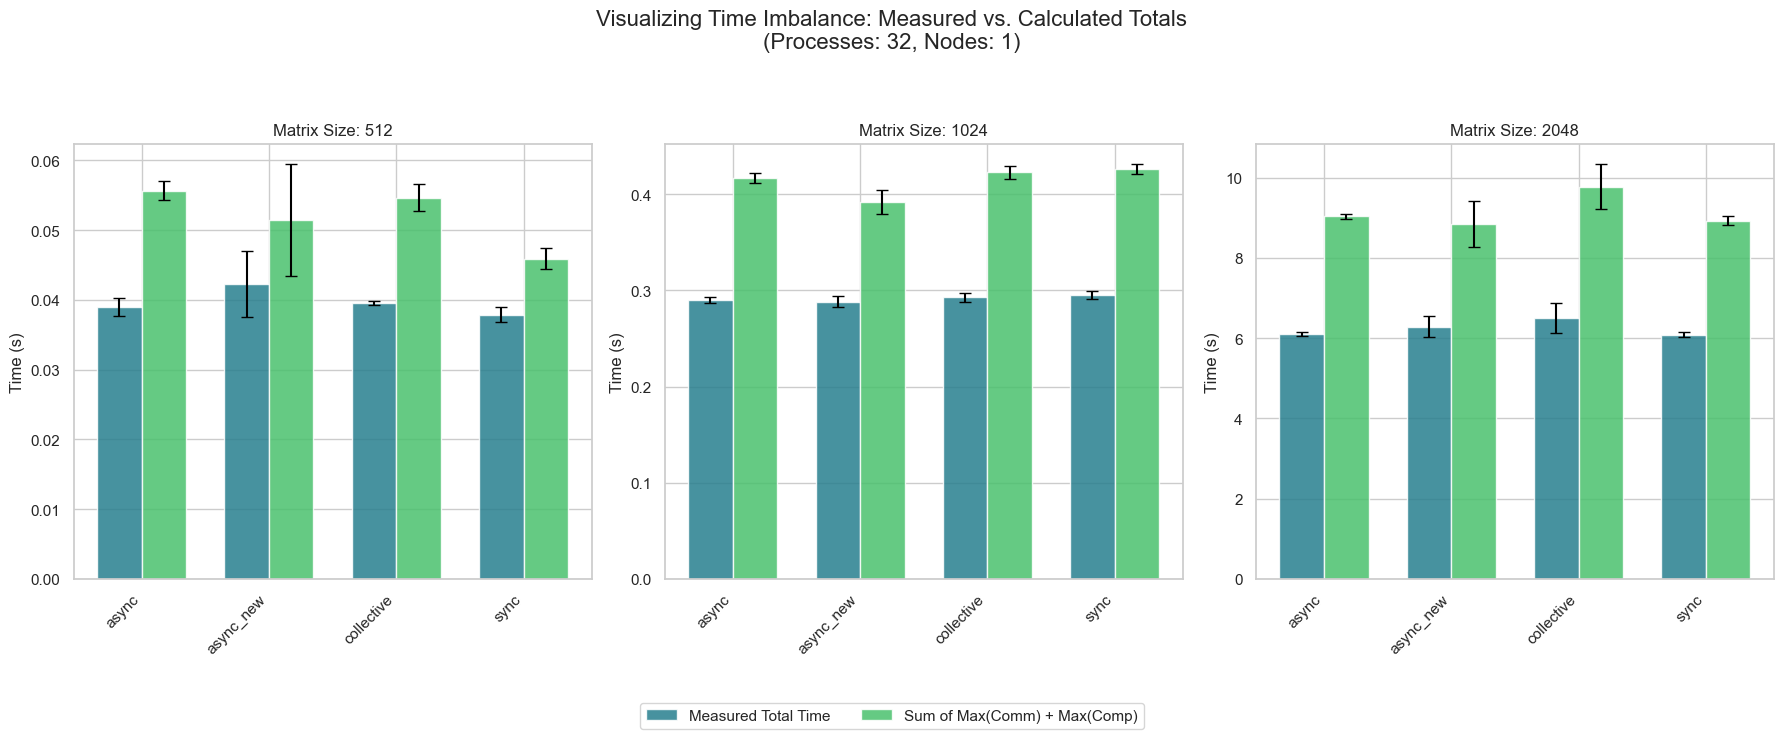

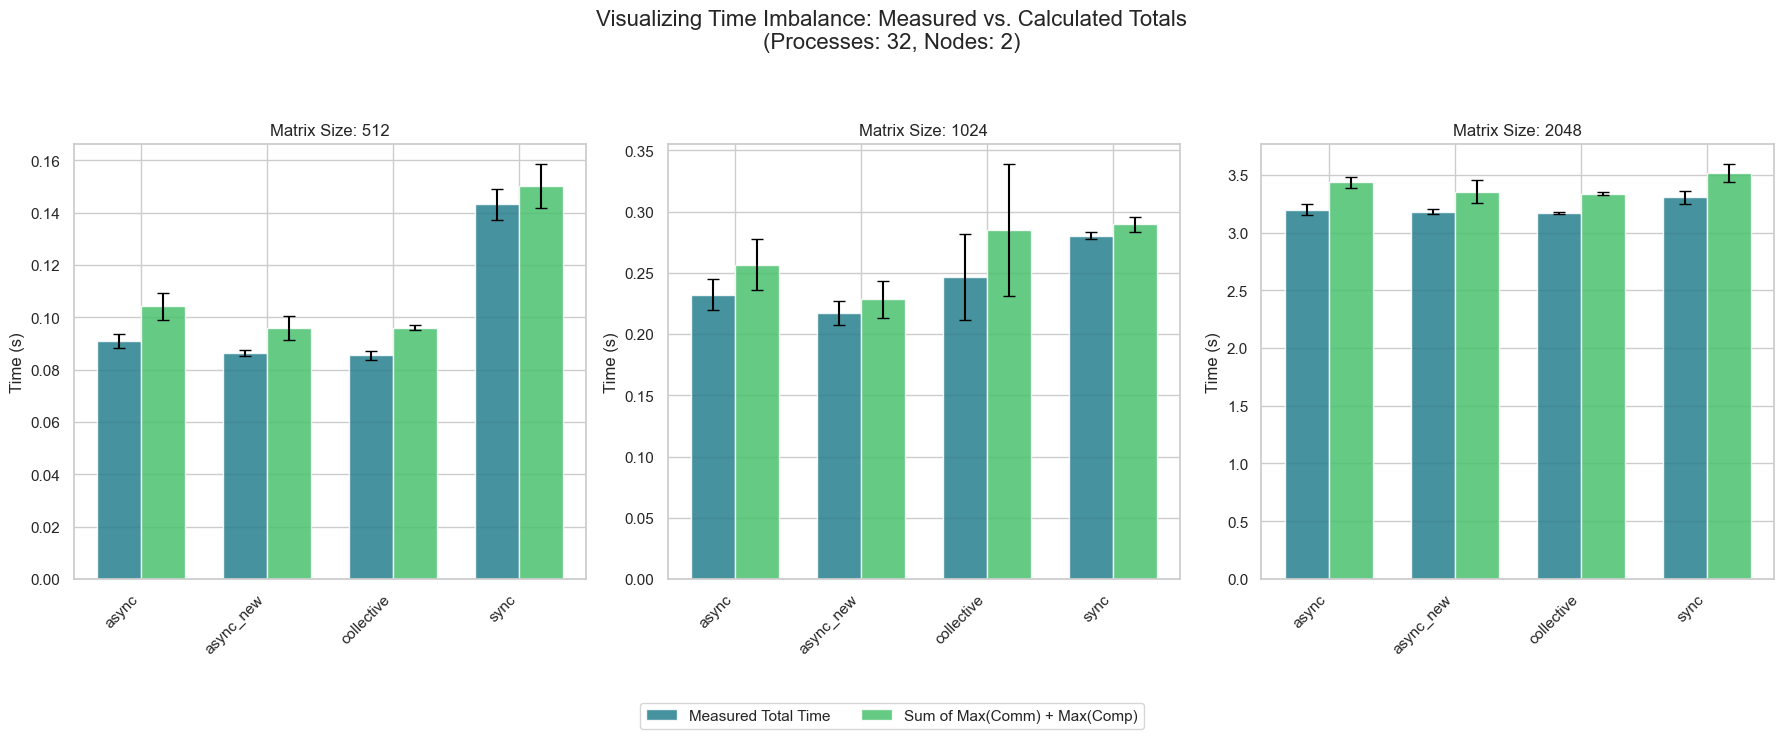

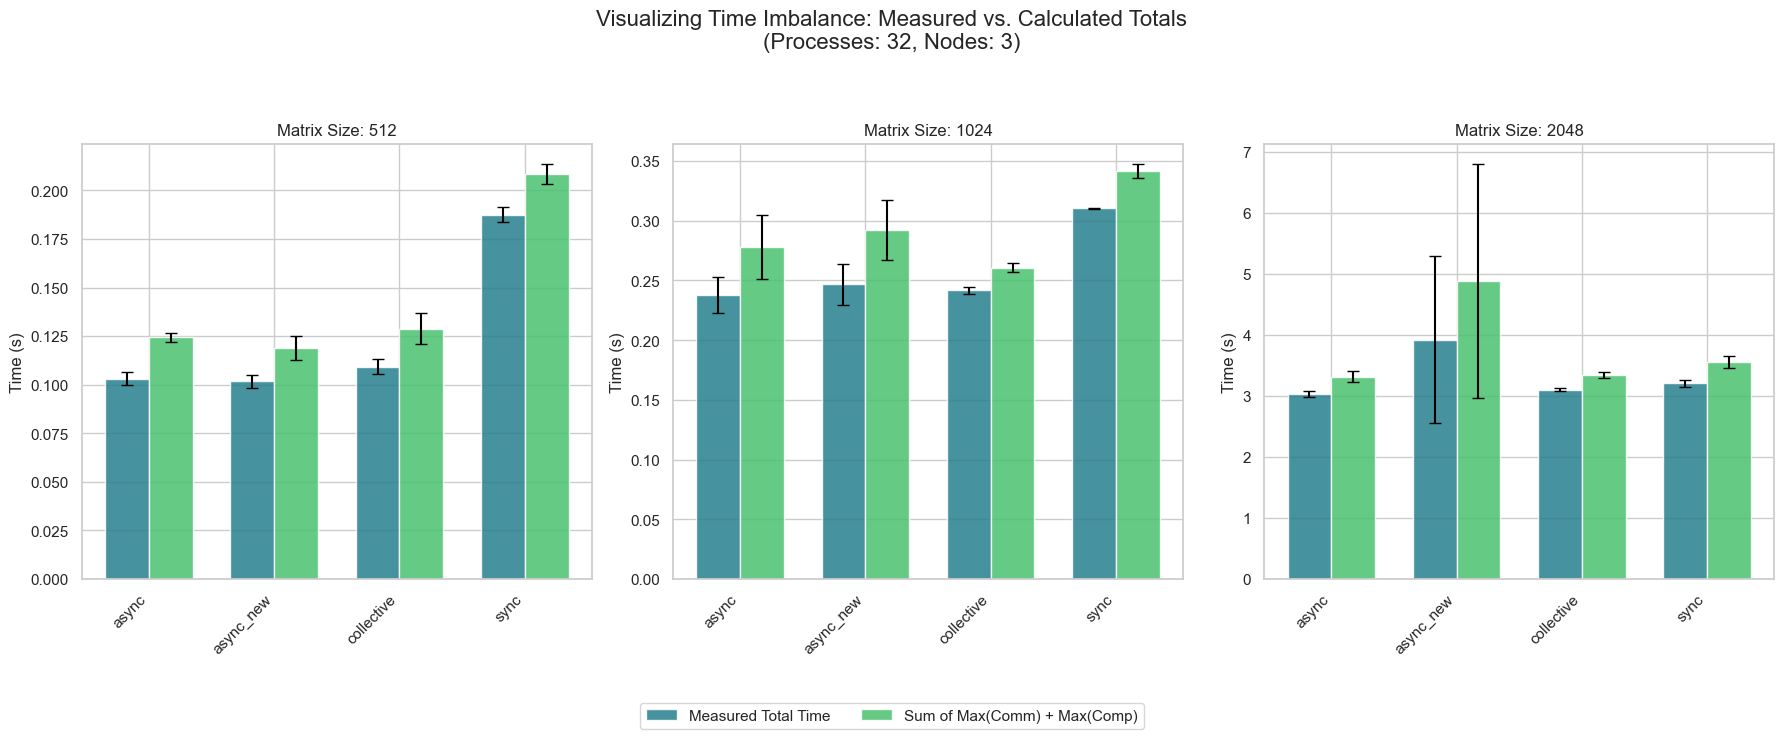

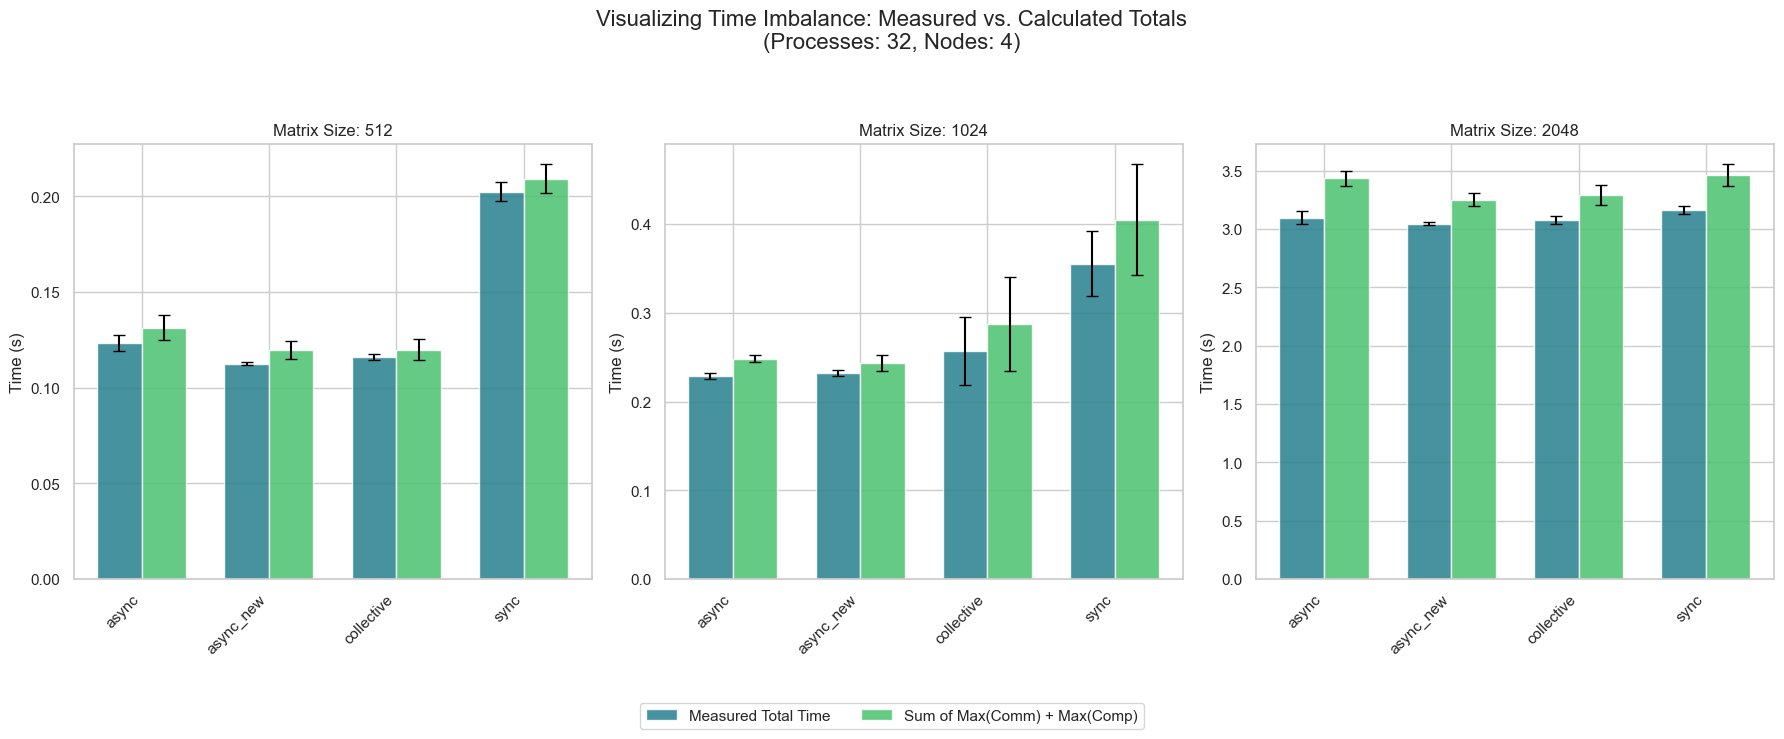

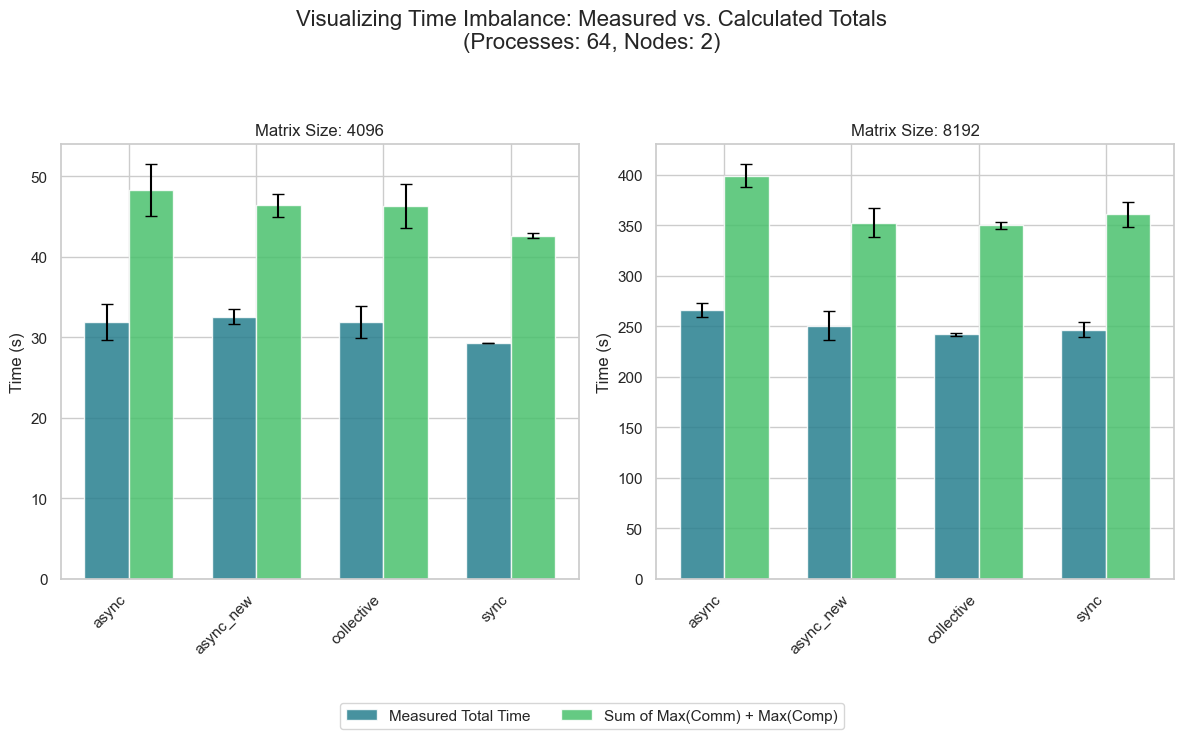

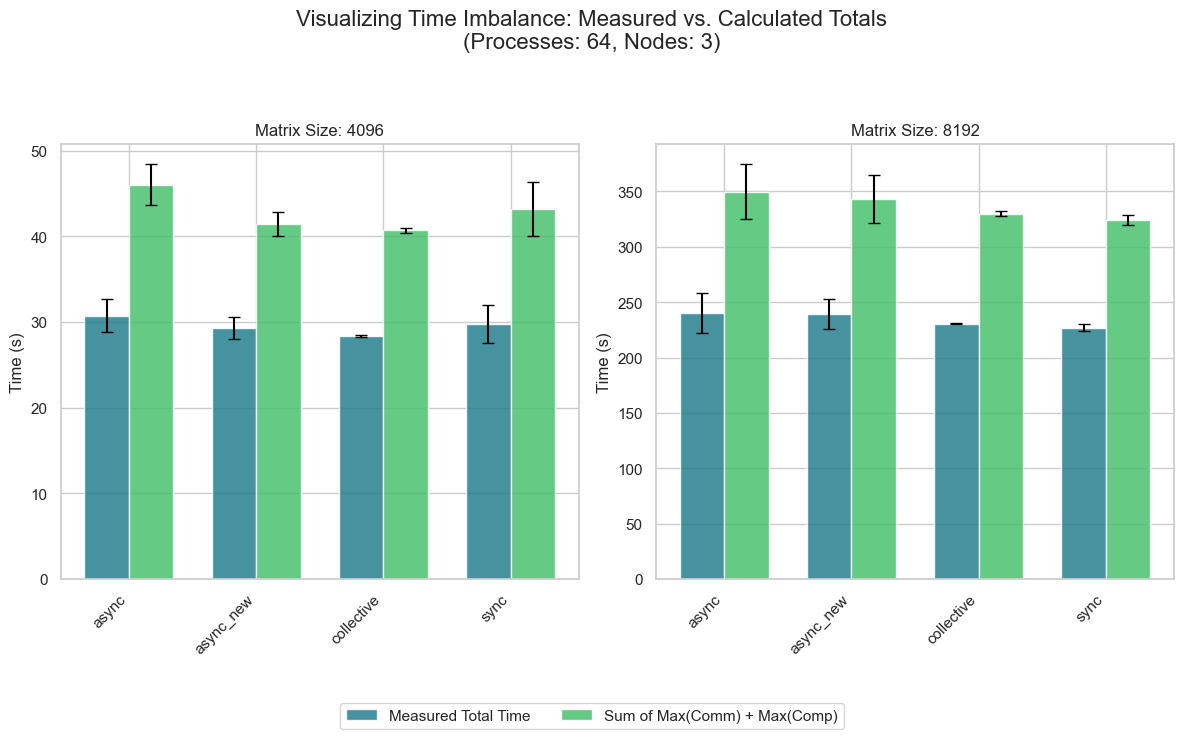

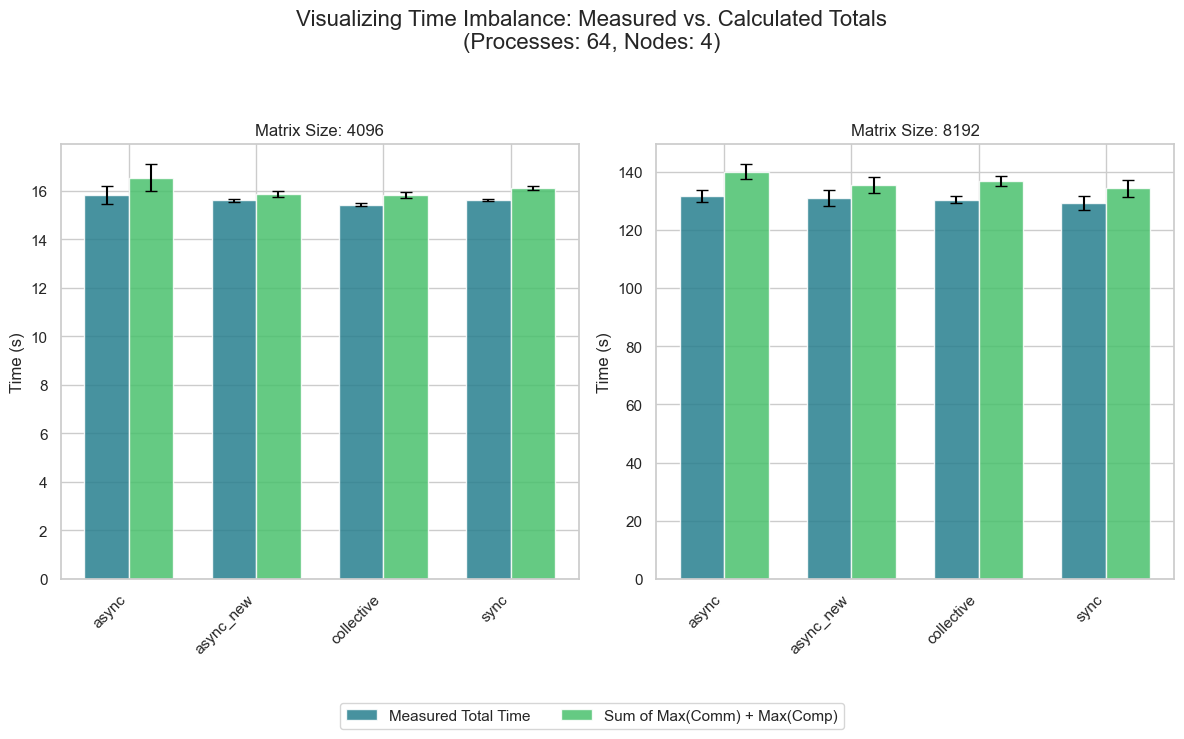

In [30]:
# Cell 3: Chart to Visualize and Explain the Time Discrepancy

# --- Step 1: Calculate the "Sum of Maximums" ---
# This is the value you got by reducing comm and comp times separately.
df['calculated_total'] = df['comm_time_mean'] + df['comp_time_mean']

# The standard deviation for this calculated total is sqrt(std_comm^2 + std_comp^2)
df['calculated_total_std'] = np.sqrt(df['comm_time_std']**2 + df['comp_time_std']**2)


# --- Step 2: Plot the Comparison for All Scenarios ---

# Get unique (num_procs, nodes) pairs to iterate over
scenario_pairs = df[['num_procs', 'nodes']].drop_duplicates().sort_values(by=['num_procs', 'nodes'])

for _, row in scenario_pairs.iterrows():
    num_procs = row['num_procs']
    nodes = row['nodes']
    
    # Filter data for the current scenario
    scenario_df = df[(df['num_procs'] == num_procs) & (df['nodes'] == nodes)]
    matrix_sizes = sorted(scenario_df['matrix_size'].unique())
    
    # Create a figure with subplots for each matrix size
    fig, axes = plt.subplots(1, len(matrix_sizes), figsize=(6 * len(matrix_sizes), 7), sharey=False)
    if len(matrix_sizes) == 1:
        axes = [axes]  # Ensure axes is always iterable

    for ax, matrix_size in zip(axes, matrix_sizes):
        # Filter data for the specific subplot
        plot_data = scenario_df[scenario_df['matrix_size'] == matrix_size].sort_values('comm_type')
        
        comm_types = plot_data['comm_type']
        x = np.arange(len(comm_types))  # the label locations
        width = 0.35  # the width of the bars

        # Bar for the "Measured Total Time" (the ground truth)
        rects1 = ax.bar(x - width/2, plot_data['total_time_mean'], width,
                        yerr=plot_data['total_time_std'], capsize=4,
                        label='Measured Total Time', color='C2', alpha=0.85)

        # Bar for the "Calculated Sum of Maximums" (the synthetic time)
        rects2 = ax.bar(x + width/2, plot_data['calculated_total'], width,
                        yerr=plot_data['calculated_total_std'], capsize=4,
                        label='Sum of Max(Comm) + Max(Comp)', color='C4', alpha=0.85)

        # The visible difference in height between these two bars is the imbalance gap
        
        ax.set_title(f'Matrix Size: {matrix_size}')
        ax.set_ylabel('Time (s)')
        ax.set_xticks(x)
        ax.set_xticklabels(comm_types, rotation=45, ha="right")

    # --- Final Touches for the Figure ---
    
    # Add a descriptive title for the entire figure
    fig.suptitle(f'Visualizing Time Imbalance: Measured vs. Calculated Totals\n(Processes: {num_procs}, Nodes: {nodes})', fontsize=16, y=1.0)
    
    # Create a single legend for the figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=2)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

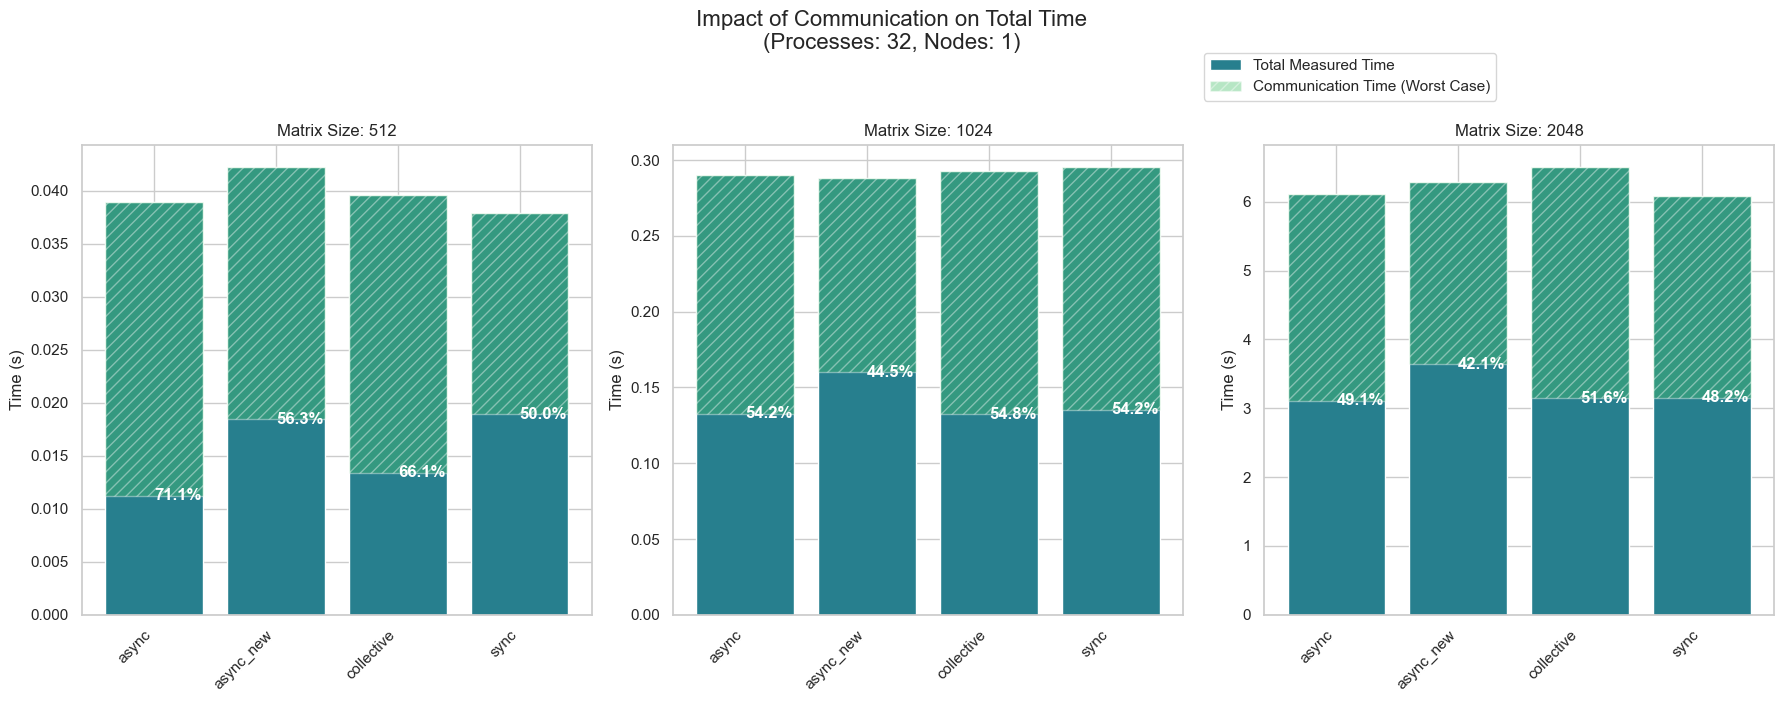

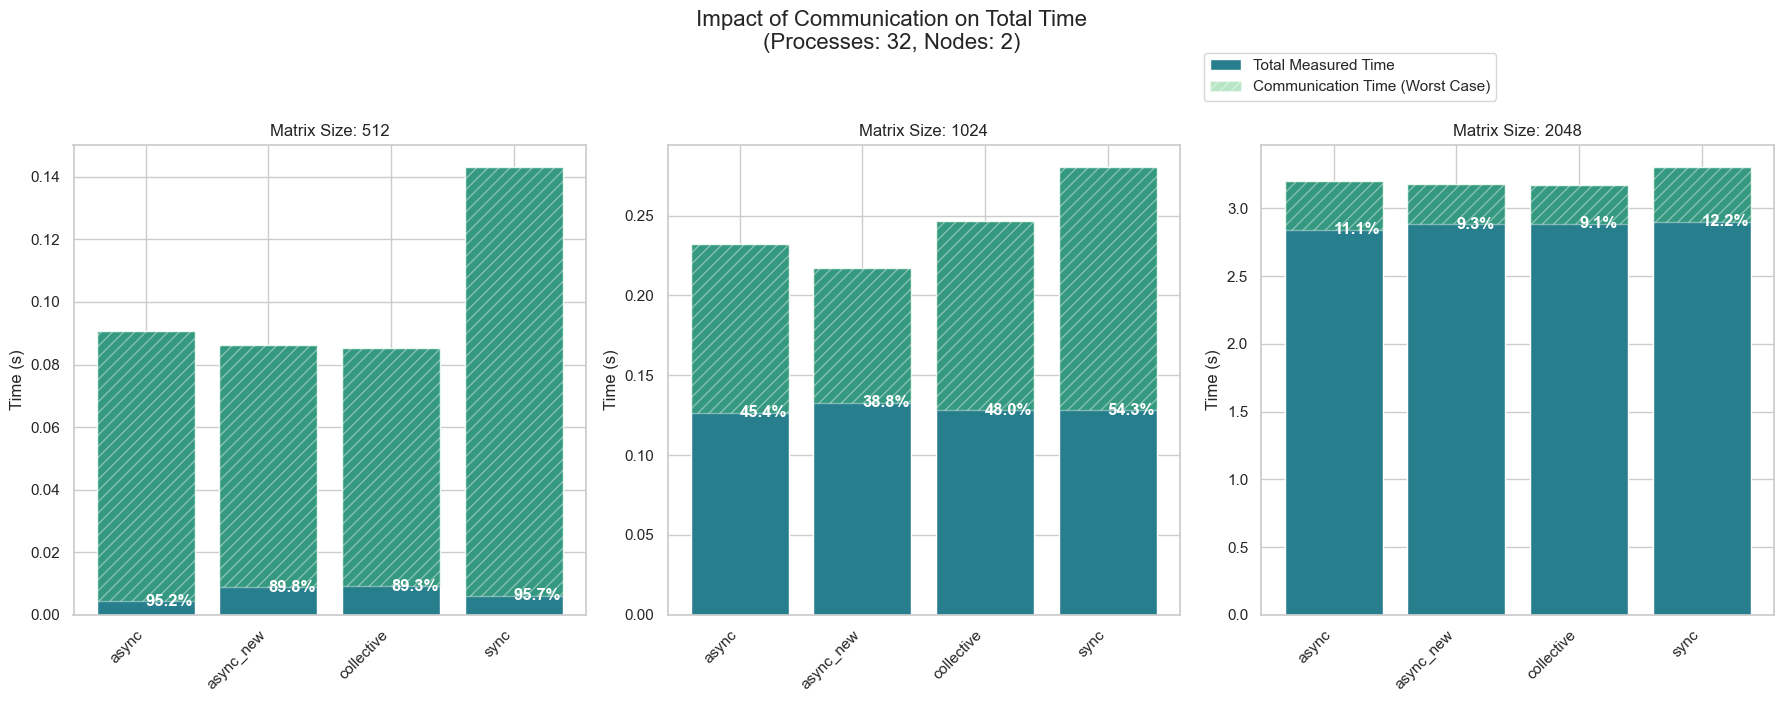

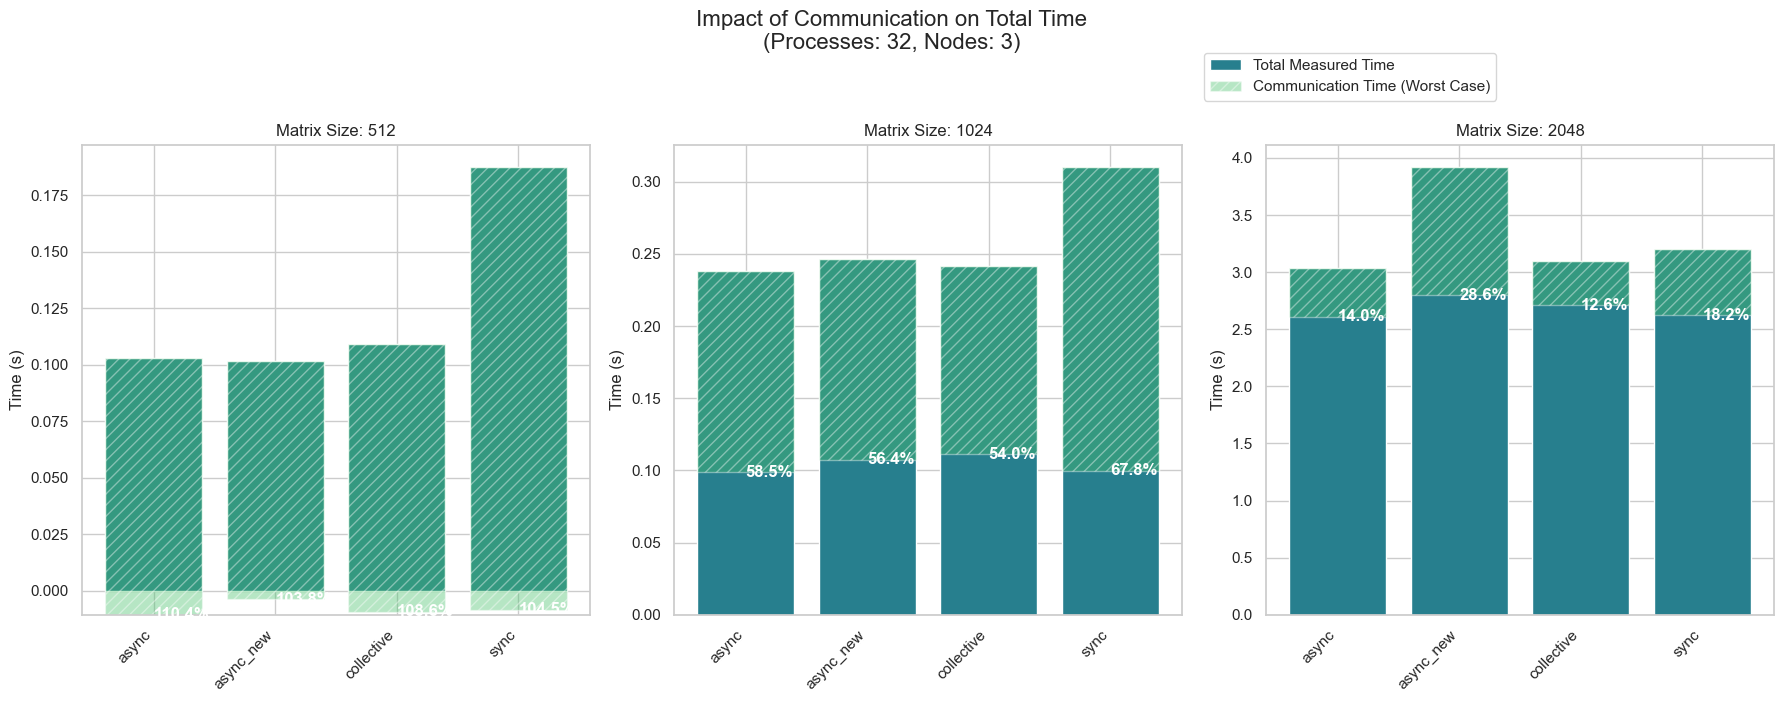

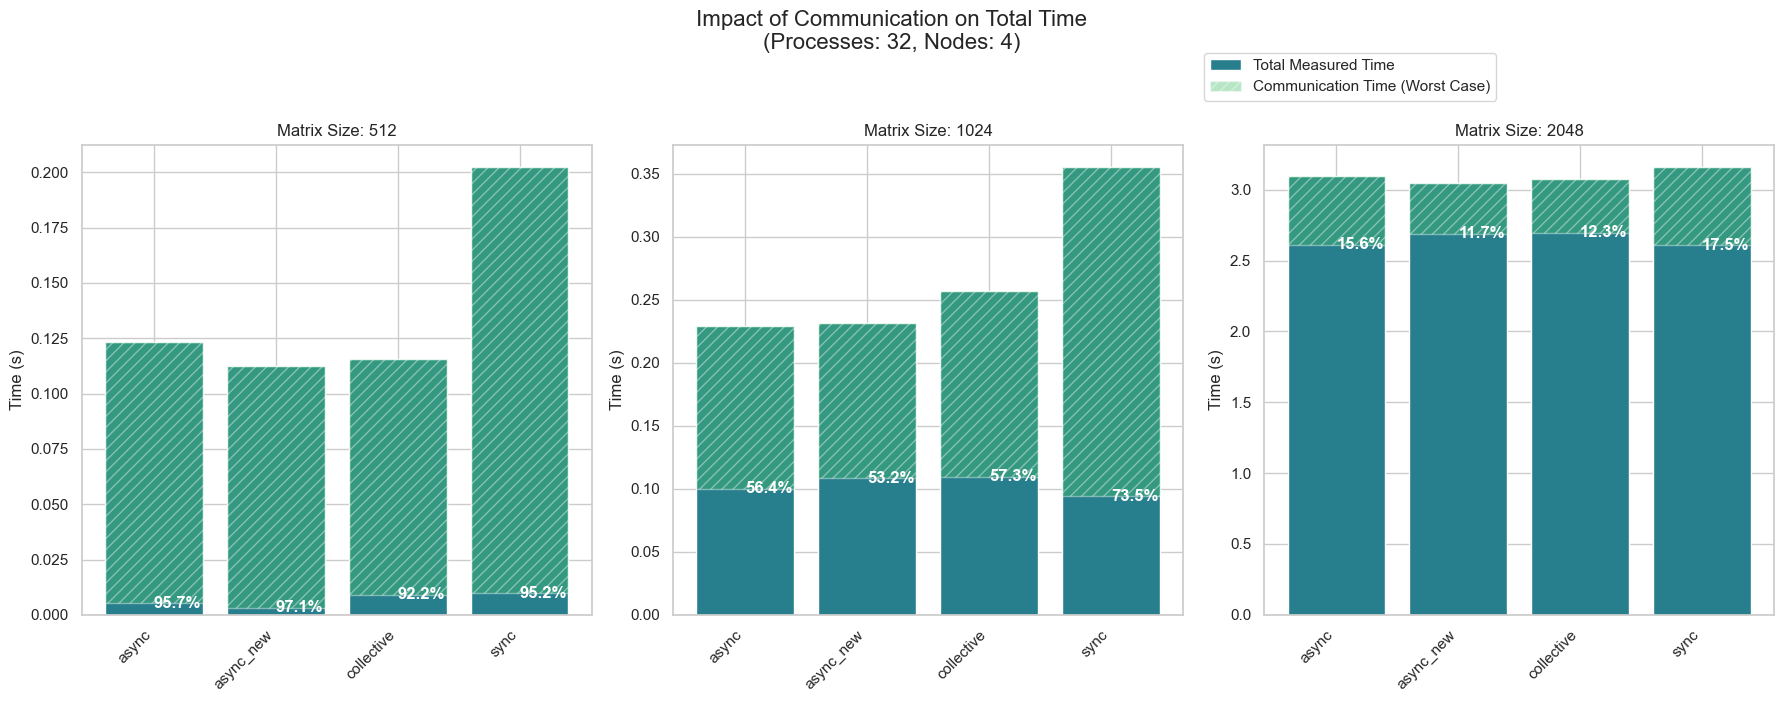

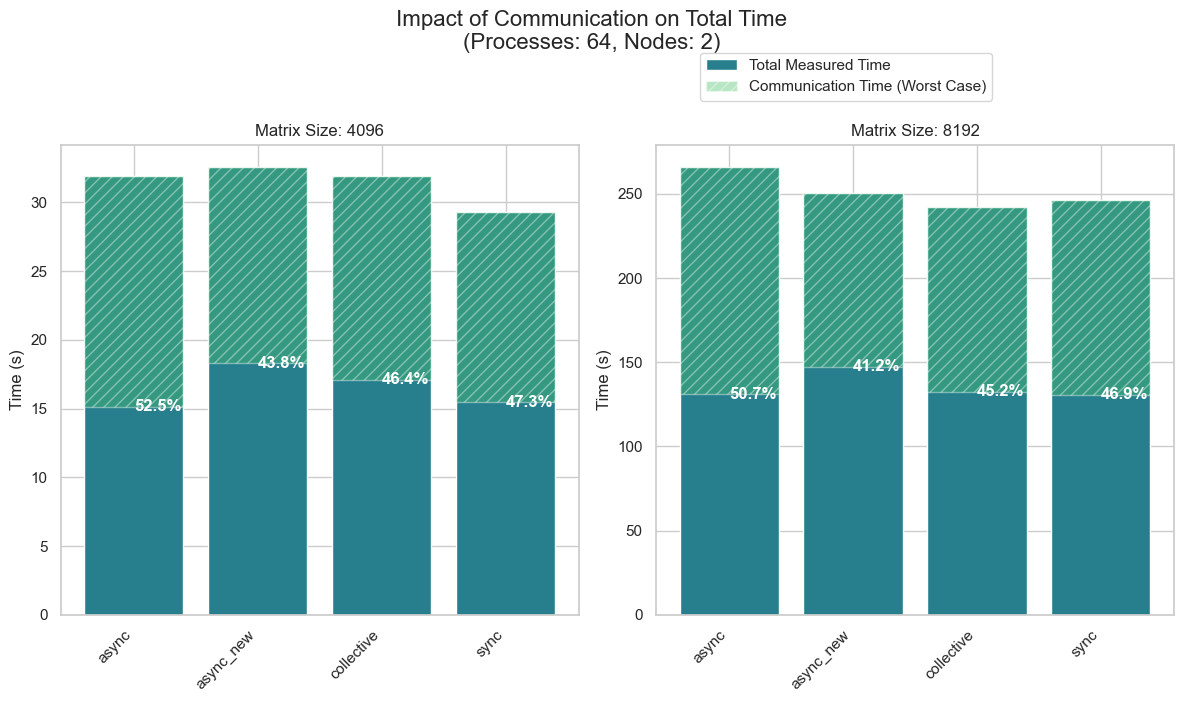

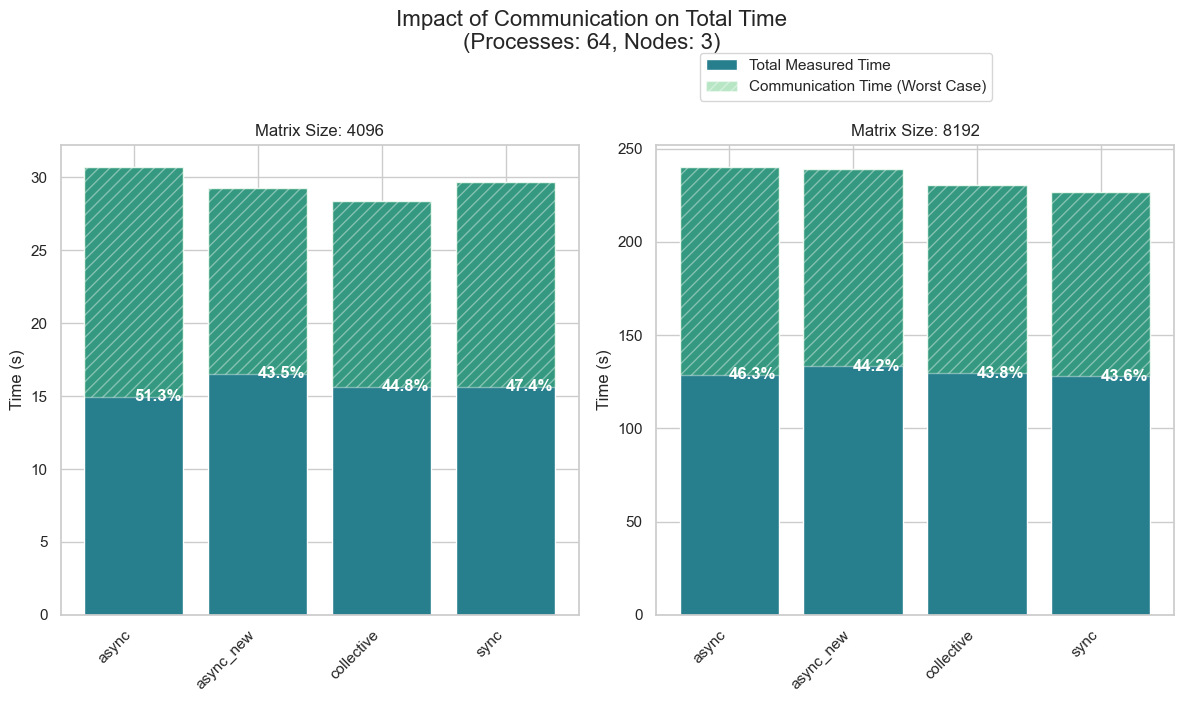

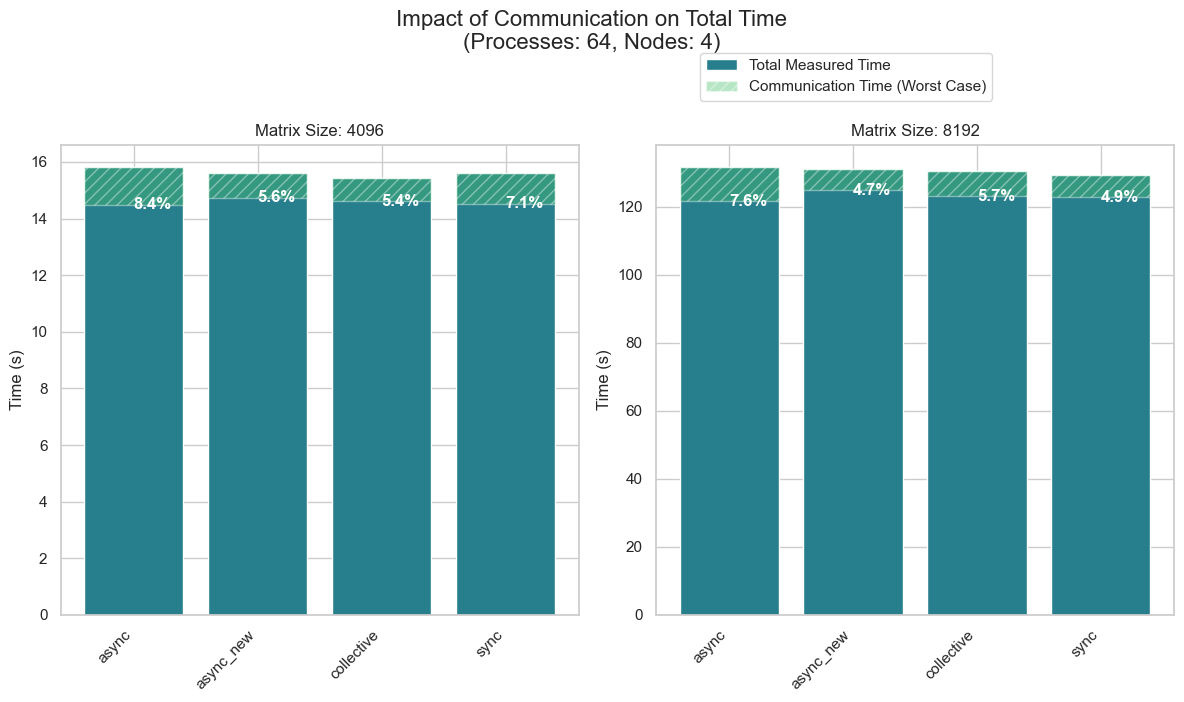

In [57]:
# Cell 5 (Corrected): Repositioning the Percentage Text

# --- Step 1: Calculate the communication percentage relative to total measured time ---
# Add a small epsilon to the denominator to prevent division by zero
epsilon = 1e-12
df['comm_percentage'] = (df['comm_time_mean'] / (df['total_time_mean'] + epsilon)) * 100


# --- Step 2: Plot the Comparison for All Scenarios ---

# Get unique (num_procs, nodes) pairs to iterate over
scenario_pairs = df[['num_procs', 'nodes']].drop_duplicates().sort_values(by=['num_procs', 'nodes'])

for _, row in scenario_pairs.iterrows():
    num_procs = row['num_procs']
    nodes = row['nodes']
    
    # Filter data for the current scenario
    scenario_df = df[(df['num_procs'] == num_procs) & (df['nodes'] == nodes)]
    matrix_sizes = sorted(scenario_df['matrix_size'].unique())
    
    # Create a figure with subplots for each matrix size
    fig, axes = plt.subplots(1, len(matrix_sizes), figsize=(6 * len(matrix_sizes), 7), sharey=False)
    if len(matrix_sizes) == 1:
        axes = [axes]  # Ensure axes is always iterable

    for ax, matrix_size in zip(axes, matrix_sizes):
        # Filter data for the specific subplot
        plot_data = scenario_df[scenario_df['matrix_size'] == matrix_size].sort_values('comm_type')
        
        comm_types = plot_data['comm_type']
        x = np.arange(len(comm_types))  # the label locations
        
        # Plot total time bars
        total_bars = ax.bar(x, plot_data['total_time_mean'],
                            label='Total Measured Time', color='C2')

        # Overlay communication bars at the top part of total time
        comm_bars = ax.bar(
            x,
            plot_data['comm_time_mean'],
            bottom=plot_data['total_time_mean'] - plot_data['comm_time_mean'],
            label='Communication Time (Worst Case)',
            color='C4',
            alpha=0.4,
            hatch='///'  # Add stripes
        )
        
        # --- Add the percentage labels next to the bars ---
        for i in range(len(total_bars)):
            bar = total_bars[i]
            height = bar.get_height()
            percentage = plot_data['comm_percentage'].iloc[i]
            comm_height = plot_data['comm_time_mean'].iloc[i]

            # --- MODIFIED ---
            # The y position is now the top of the total bar minus the communication bar height
            y_position = height - comm_height

            # Place text to the right of the bar, vertically centered on the intersection line
            ax.text(
                bar.get_x() + bar.get_width()/2,  # x position
                y_position,                       # y position
                f'{percentage:.1f}%',             # The text
                ha='left',                        # Horizontal alignment
                va='center',                      # Vertical alignment
                fontsize=12,
                fontweight='bold',
                color='white'                     # Set text color to white
            )

        ax.set_title(f'Matrix Size: {matrix_size}')
        ax.set_ylabel('Time (s)')
        ax.set_xticks(x)
        ax.set_xticklabels(comm_types, rotation=45, ha="right")

    # --- Final Touches for the Figure ---
    
    # Adjust right margin to make space for text labels
    fig.subplots_adjust(right=0.85)

    # Add a descriptive title for the entire figure
    fig.suptitle(f'Impact of Communication on Total Time\n(Processes: {num_procs}, Nodes: {nodes})', fontsize=16, y=1.0)
    
    # Create a single legend for the figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.84, 0.95))
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

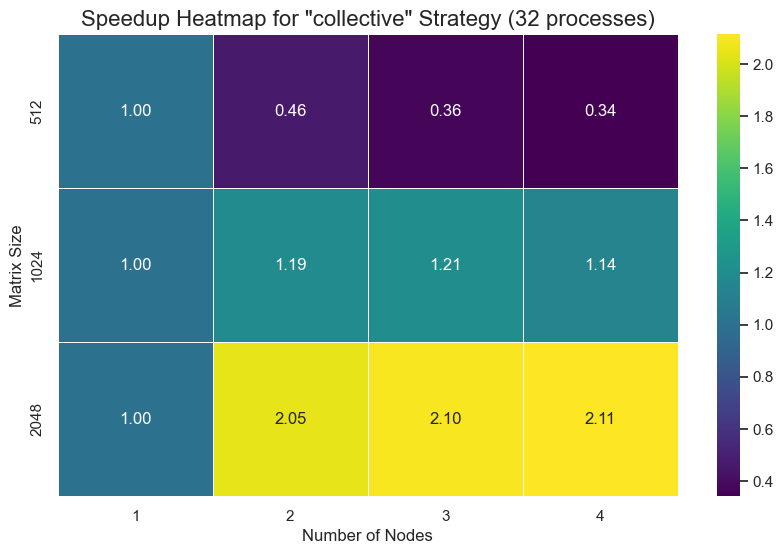

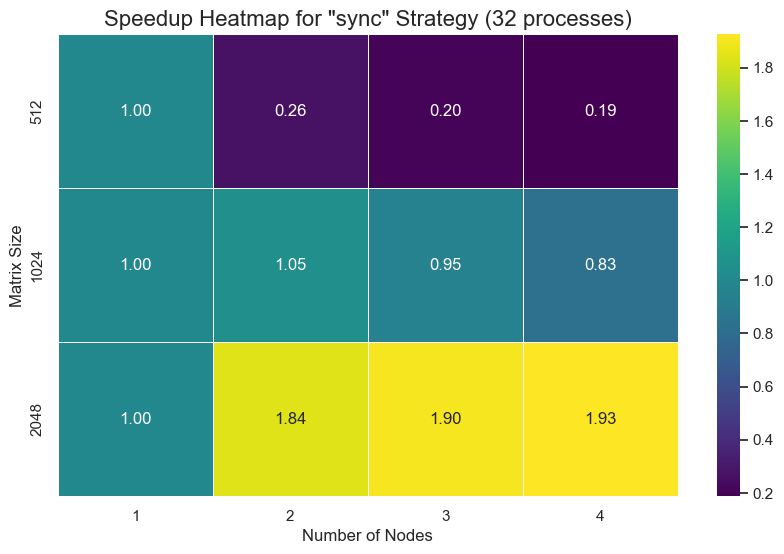

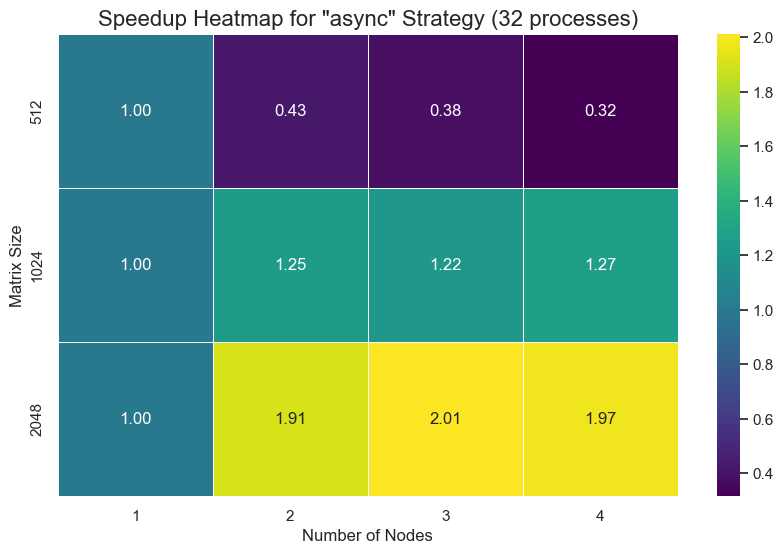

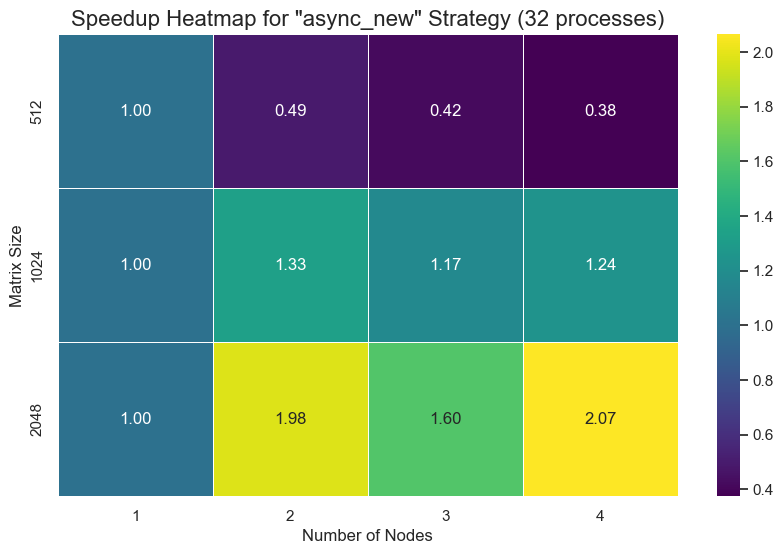

In [59]:
# Chart 2: Speedup Heatmap

# First, we need to calculate Speedup.
# The baseline is the time taken on 1 node for each (matrix_size, comm_type, num_procs).
baseline_df = df[df['nodes'] == 1].copy()
baseline_df = baseline_df.rename(columns={'total_time_mean': 'baseline_time'})
baseline_df = baseline_df[['matrix_size', 'comm_type', 'num_procs', 'baseline_time']]

# Merge the baseline time back into the main dataframe
df_speedup = pd.merge(df, baseline_df, on=['matrix_size', 'comm_type', 'num_procs'])

# Calculate speedup = T_baseline / T_parallel
df_speedup['speedup'] = df_speedup['baseline_time'] / df_speedup['total_time_mean']


# Now, create a heatmap for each scenario
for procs in df_speedup['num_procs'].unique():
    for comm in df_speedup['comm_type'].unique():
        
        subset = df_speedup[(df_speedup['num_procs'] == procs) & (df_speedup['comm_type'] == comm)]
        
        # We can only plot if there is data for more than one node
        if 1 in subset['nodes'].unique() and len(subset['nodes'].unique()) > 1:
            
            # Pivot the data to create a 2D matrix for the heatmap
            heatmap_data = subset.pivot_table(index='matrix_size', columns='nodes', values='speedup')
            
            plt.figure(figsize=(10, 6))
            sns.heatmap(
                heatmap_data,
                annot=True,          # Show the speedup values in the cells
                fmt=".2f",           # Format to two decimal places
                cmap="viridis",      # Use the viridis color map
                linewidths=.5
            )
            plt.title(f'Speedup Heatmap for "{comm}" Strategy ({procs} processes)', fontsize=16)
            plt.ylabel('Matrix Size')
            plt.xlabel('Number of Nodes')
            plt.show()